# Economics Tie-In

It's considered general knowledge that the worse state the economy/country is in, the better the entertainment industry does. But is this true? Can we see any sort of relationship between the state of the film industry and the standings of average means in the US?

To find out, we will be using two datasets (one for average wages by metric, and one for unemployment rates by metric) to create one economic DataFrame (DF) from which we can draw our comparrisons.

In [1]:
# Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Data

---

The following datasets are courtesy of __[Kaggle](https://www.kaggle.com/)__.

### __['...CCI_OECD.csv'](https://www.kaggle.com/datasets/iqbalsyahakbar/cci-oecd)__

*renamed from `DP_LIVE_16112023095843236.csv`*

Per the Organisation for Economic Co-operation and Development (OECD);

* The Consumer Confidence Indicator (CCI) is an indication of developments for future households' consumption and saving based on expected financial situation, sentiment regarding the general economic situation, employment status, and capacity for savings
* An indicator above `100` indicates an optimistic outlook and a greater likliehood to spend money over cautious saving
* An indicator below `100` indicates a pessimistic outlook and both a higher likeliehood to save money and a lower tendency to consume

### __['...US_inflation_rates.csv'](https://www.kaggle.com/datasets/pavankrishnanarne/us-inflation-dataset-1947-present)__

Per the dataset description;

* The Consumer Price Index (CPI) is a critical economic indicator for measuring the purchasing power of money over time, measuring the average change over time in the prices paid by urban consumers for goods and services
* The CPI is the value at the end of the respective month

### __['...public_debt.csv'](https://www.kaggle.com/datasets/pavankrishnanarne/us-public-debt-quarterly-data-1996-present)__

Per the dataset description;

* Public debt, or government debt, represents the total outstanding bonds and other securities of a country's central government
* The provided `value` represents the quarterly US public debt in billions of US Dollars (USD)

---

The following datasets are courtesy of the __[Economic Policy Institute’s (EPI) State of Working America Data Library](https://www.epi.org/data/)__.

### __['...Medianaverage hourly wages.csv'](https://www.epi.org/data/#?subject=wage-avg)__

Per EPI description;

* Wages adjusted to 2023 dollars by the Consumer Price Index for All Urban Consumers Research Series
* `Median Wage` is the hourly wage in the middle of the wage distribution
* `Average Wage` is the calculated mean of all wages

### __['...Unemployment.csv'](https://www.epi.org/data/#?subject=unemp)__

Per EPI description;

* Unemployment is the share of the labor force wihout a job
* Monthly percentages calculated as a rolling 12-month average (mean)

In [2]:
# Reading in data
df_hourly_wages = pd.read_csv("./Resources/EPI Data Library - Medianaverage hourly wages.csv")
df_unemp = pd.read_csv("./Resources/EPI Data Library - Unemployment.csv")
df_cci = pd.read_csv("./Resources/CCI_OECD.csv")
df_inflation = pd.read_csv("./Resources/US_inflation_rates.csv")
df_public_debt = pd.read_csv("./Resources/public_debt.csv")

# Defining functions

Since each dataset will need similar preprocessing, the following functions will be used to help streamline the flow and code.

### Universal functions

Applicable to all datasets

#### Copying datasets

Creating a working copy of a given dataset to preserve the original DF with unneeded features dropped

#### Renaming needed features

Renaming selected features for a given dataset

#### Rolling mean and mean percent change

Calculating the rolling 12-month mean and the rolling 12-month percent change for a given feature

In [3]:
# Defining a function to copy a dataset with only the needed features
def copy_df(df, features_to_keep):
    df_copy = df[features_to_keep].copy()
    return df_copy

# Defining a function to rename needed features
def rename_features(df, feature1, feature1new, feature2, feature2new):
    df.rename(columns={
        feature1: feature1new,
        feature2: feature2new
    }, inplace=True)
    return df

# Defining a function to calculate the rolling 12-month means and percent changes
# for a given feature
def rolling_calcs(df, feature, feature_mean, feature_pct_chng):
    df[feature_mean] = df[feature].rolling(window=12).mean()
    df[feature_pct_chng] = df[feature_mean].pct_change(periods=12) * 100
    return df

### Situational functions

Applicable to select datasets

#### Datetime indexing

Converting the feature containing the raw datetime information into a suitable datetime index

*Cannot be used on `Hourly Wages` or `Unemployment` datasets*

#### Forward filling

Resampling by using quarterly or annual data to fill in the missing months of a datetime index

*For `Public Debt` and `Hourly Wages` datasets*

#### Removing '$'

Removing the `'$'` from a given feature and converting the remaining `object` dtype to `float`

*Sepcifically for `Hourly Wages` dataset*

#### Removing '%'

Removing the `'%'` from a given feature and converting the remaining `object` dtype to `float`

*Specigically for `Unemployment` dataset*

In [4]:
# Defining a function to set a `Date` feature as a datetime index
def datetime_index(df, datetime_feature):
    df[datetime_feature] = pd.to_datetime(df[datetime_feature])
    df.set_index(datetime_feature, inplace=True)
    df.sort_index(inplace=True)
    return df

# Defining a function to resample missing months by forward filling the datetime index
def forward_fill(df):
    df = df.resample('MS').ffill()
    return df

# Defining a function to remove '$' and convert data to `float`
def convert_dollars(feature):
    if isinstance(feature, str):
        return float(feature.strip('$'))
    return feature

# Defining a function to apply `convert_dollars`
def apply_dollars(df, feature):
    df[feature] = df[feature].apply(convert_dollars)
    return df

# Defining a function to remove '%' and convert data `float`
def convert_percentage(feature):
    return float(feature.strip('%'))

# Defining a function to apply `convert_percentage`
def apply_percentage(df, feature):
    df[feature] = df[feature].apply(convert_percentage)
    return df

# CCI

#### Preprocessing of the `CCI_OECD.csv` dataset

This dataset came with internaitonal records and unneeded features, so only records for US CCI will be retained. Once those records have been selected, the resulting DF will need to be prepared for concatenation with the remainined economic datasets. To do this, the `TIME` feature will be converted to datetime and set as the index.

In [5]:
# Viewing `df_cci`
df_cci.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-01,101.4526,NaN
1,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-02,101.4332,NaN
2,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-03,101.2753,NaN
3,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-04,101.0106,NaN
4,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-05,100.8543,NaN


#### Beginning of limited EDA

In [6]:
# Beginning EDA on `df_cci`
df_cci.describe()

,Value,Flag Codes
count,21552.000000,0.0
mean,100.017942,NaN
std,1.973255,NaN
min,86.618690,NaN
25%,98.897823,NaN
50%,100.279300,NaN
75%,101.263550,NaN
max,108.773100,NaN


In [7]:
# Continuing EDA
df_cci.shape

(21552, 8)

In [8]:
# Continuing EDA
df_cci.dtypes

LOCATION       object
INDICATOR      object
SUBJECT        object
MEASURE        object
FREQUENCY      object
TIME           object
Value         float64
Flag Codes    float64
dtype: object

In [9]:
# Continuing EDA
df_cci['LOCATION'].unique()

array(['NLD', 'CHE', 'FRA', 'POL', 'CZE', 'JPN', 'OECDE', 'AUS', 'OECD',
       'SWE', 'MEX', 'GBR', 'ZAF', 'USA', 'HUN', 'PRT', 'DNK', 'ESP',
       'LUX', 'GRC', 'BRA', 'SVK', 'CHN', 'BEL', 'FIN', 'NZL', 'G-7',
       'IDN', 'TUR', 'AUT', 'ITA', 'IRL', 'SVN', 'DEU', 'KOR', 'EST',
       'EA19', 'ISR', 'RUS', 'LVA', 'LTU', 'G7M', 'OEU', 'COL', 'CHL',
       'CRI', 'IND', 'G-20', 'EU27_2020'], dtype=object)

#### Selecting only domestic data

In [10]:
# Copying domestic data from `df_cci` to `df_cci_us` and removing unneeded features
df_cci_us = df_cci.loc[df_cci['LOCATION'] == 'USA'].copy()

#### Applying defined functions

In [11]:
# Copying `df_cci_us` and dropping unneeded features
df_cci_form = copy_df(df_cci_us, ['TIME', 'Value'])

# Renamining retained features
df_cci_form = rename_features(
    df_cci_form, 'TIME', 'Date', 'Value', 'CCI Value'
)

# Converting `Date` to a datetime index
df_cci_form = datetime_index(df_cci_form, 'Date')

# Calculating rolling 12-month means and percent change in means
df_cci_form = rolling_calcs(
    df_cci_form, 'CCI Value', 'CCI Rolling Mean', 'CCI Rolling Percent Change'
)

# Confirming `df_cci_form` ready to concatenate
display(df_cci_form.head())
display(df_cci_form.tail())

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change
Date,,,
1960-01-01,101.6304,NaN,NaN
1960-02-01,101.3717,NaN,NaN
1960-03-01,101.1483,NaN,NaN
1960-04-01,101.0250,NaN,NaN
1960-05-01,101.0561,NaN,NaN


,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change
Date,,,
2023-06-01,97.54726,97.009973,-0.720943
2023-07-01,97.90887,97.153842,-0.314425
2023-08-01,97.98888,97.282601,0.008370
2023-09-01,97.82825,97.380064,0.256435
2023-10-01,97.52642,97.442995,0.444103


# Inflation

#### Preprocessing of the `US_inflation_rates.csv` dataset

Seeing as the dataset came with only the needed features, little will be needed to prepare the DF for concatenation with the other economic datasets. `date` will be converted to datetime and set as the index.

In [12]:
# Viewing `df_inflation`
df_inflation.head()

,date,value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


#### Beginning on limited EDA

In [13]:
# Beginning of EDA on `df_inflation`
df_inflation.describe()

,value
count,918.000000
mean,117.794828
std,83.736360
min,21.480000
25%,32.105000
50%,106.900000
75%,188.000000
max,303.841000


In [14]:
# Continuing EDA
df_inflation.shape

(918, 2)

In [15]:
# Continuing EDA
df_inflation.dtypes

date      object
value    float64
dtype: object

#### Applying defined functions

In [16]:
df_inflation.columns

Index(['date', 'value'], dtype='object')

In [17]:
# Copying `df_inflation` and dropping unneeded features
df_inflation_form = copy_df(df_inflation, ['date', 'value'])

# Renamining retained features
df_inflation_form = rename_features(
    df_inflation_form, 'date', 'Date', 'value', 'CPI Value'
)

# Converting `Date` to a datetime index
df_inflation_form = datetime_index(df_inflation_form, 'Date')

# Calculating rolling 12-month means and percent change in means
df_inflation_form = rolling_calcs(
    df_inflation_form,
    'CPI Value',
    'CPI Rolling Mean',
    'CPI Rolling Percent Change'
)

# Confirming `df_inflation_form` ready to concatenate
display(df_inflation_form.head())
display(df_inflation_form.tail())

,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change
Date,,,
1947-01-01,21.48,NaN,NaN
1947-02-01,21.62,NaN,NaN
1947-03-01,22.00,NaN,NaN
1947-04-01,22.00,NaN,NaN
1947-05-01,21.95,NaN,NaN


,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change
Date,,,
2023-02-01,301.648,295.527083,7.706636
2023-03-01,301.808,296.721750,7.406182
2023-04-01,302.918,297.914000,7.128724
2023-05-01,303.294,298.916167,6.758919
2023-06-01,303.841,299.675583,6.265739


# Public Debt

#### Preprocessing of the `public_debt.csv` dataset

Since this datset came as quarterly values, both converting `date` to datetime and the index will be necessary to resample for the missing months. Once the values are forward filled, the DF will be ready to concatenate with the other economic datasets.

In [18]:
# Viewing `df_public_debt`
df_public_debt.head()

,date,value
0,1966-01-01,320999.0
1,1966-04-01,316097.0
2,1966-07-01,324748.0
3,1966-10-01,329319.0
4,1967-01-01,330947.0


#### Beginning of limited EDA

In [19]:
# Beginning of EDA on `df_public_debt`
df_public_debt.describe()

,value
count,2.290000e+02
mean,7.408932e+06
std,8.189013e+06
min,3.160970e+05
25%,8.776140e+05
50%,4.692750e+06
75%,1.069980e+07
max,3.145844e+07


In [20]:
# Continuing EDA
df_public_debt.shape

(229, 2)

In [21]:
# Continuing EDA
df_public_debt.dtypes

date      object
value    float64
dtype: object

#### Applying defined functions

In [22]:
# Copying `df_public_debt` and dropping unneeded features
df_public_debt_form = copy_df(df_public_debt, ['date', 'value'])

# Renamining retained features
df_public_debt_form = rename_features(
    df_public_debt_form, 'date', 'Date', 'value', 'Public Debt (bil USD)'
)

# Converting `Date` to a datetime index
df_public_debt_form = datetime_index(df_public_debt_form, 'Date')

# Forward filling missing months
df_public_debt_form = forward_fill(df_public_debt_form)

# Calculating rolling 12-month means and percent change in means
df_public_debt_form = rolling_calcs(
    df_public_debt_form,
    'Public Debt (bil USD)',
    'Public Debt (bil USD) Rolling Mean',
    'Public Debt Rolling Percent Change'
)

# Confirming `df_public_debt_form` ready to concatenate
display(df_public_debt_form.head())
display(df_public_debt_form.tail())

,Public Debt (bil USD),Public Debt (bil USD) Rolling Mean,Public Debt Rolling Percent Change
Date,,,
1966-01-01,320999.0,NaN,NaN
1966-02-01,320999.0,NaN,NaN
1966-03-01,320999.0,NaN,NaN
1966-04-01,316097.0,NaN,NaN
1966-05-01,316097.0,NaN,NaN


,Public Debt (bil USD),Public Debt (bil USD) Rolling Mean,Public Debt Rolling Percent Change
Date,,,
2022-09-01,30928912.0,3.037892e+07,7.689688
2022-10-01,31419689.0,3.052912e+07,7.627789
2022-11-01,31419689.0,3.067933e+07,7.566566
2022-12-01,31419689.0,3.082954e+07,7.506009
2023-01-01,31458438.0,3.091766e+07,7.107277


## Hourly Wages

#### Preprocessing of the `Medianaverage hourly wages.csv` dataset

This dataset came with unneeded features that will need to be dropped, as well as the needed features will need to be converted to `float`. Additionally, as an annual measures of mean and median wages, the `Date` feature will need to be converted to datetime and set to the index in order to resample for the missing months. Once the values are forward filled, the DF will be ready to concatenate with with other economic datasets.

In [23]:
# Viewing `df_hourly_wages`
df_hourly_wages.head()

,Date,Median,Average,Men Median,Men Average,Women Median,Women Average,White Median,White Average,Black Median,...,Black Women Median,Black Women Average,Hispanic Women Median,Hispanic Women Average,Recent high-school graduate,Men Recent high-school graduate,Women Recent high-school graduate,Recent college graduate,Men Recent college graduate,Women Recent college graduate
0,2023,$23.75,$33.50,$25.06,$36.98,$21.80,$29.74,$25.97,$36.09,$20.11,...,$19.93,$25.59,$18.30,$23.60,$16.16,$17.11,$14.76,$25.93,$28.59,$24.01
1,2022,$23.31,$33.31,$25.29,$37.29,$21.08,$29.00,$25.96,$35.90,$20.39,...,$19.75,$24.98,$18.28,$23.53,$16.48,$17.47,$15.00,$25.14,$27.48,$23.41
2,2021,$23.74,$33.43,$25.92,$37.11,$21.85,$29.46,$26.49,$35.94,$20.26,...,$19.69,$25.14,$18.48,$23.86,$15.87,$16.46,$15.02,$26.10,$28.97,$24.03
3,2020,$24.09,$33.95,$26.56,$37.60,$22.53,$30.01,$27.22,$36.38,$20.79,...,$20.05,$25.95,$18.29,$24.03,$15.29,$16.11,$14.11,$27.38,$28.68,$26.46
4,2019,$22.94,$31.71,$24.75,$35.14,$21.01,$28.02,$25.49,$34.24,$19.19,...,$18.88,$24.20,$17.92,$22.45,$15.34,$16.21,$14.08,$24.97,$27.08,$23.46


#### Beginning of limited EDA

In [24]:
# Beginning EDA on `df_hourly_wages`
df_hourly_wages.describe()

,Date
count,51.000000
mean,1998.000000
std,14.866069
min,1973.000000
25%,1985.500000
50%,1998.000000
75%,2010.500000
max,2023.000000


In [25]:
# Continuing EDA
df_hourly_wages.shape

(51, 31)

In [26]:
# Continuing EDA
df_hourly_wages.dtypes

Date                                  int64
Median                               object
Average                              object
Men Median                           object
Men Average                          object
Women Median                         object
Women Average                        object
White Median                         object
White Average                        object
Black Median                         object
Black Average                        object
Hispanic Median                      object
Hispanic Average                     object
White Men Median                     object
White Men Average                    object
Black Men Median                     object
Black Men Average                    object
Hispanic Men Median                  object
Hispanic Men Average                 object
White Women Median                   object
White Women Average                  object
Black Women Median                   object
Black Women Average             

#### Applying defined functions (first pass)

*Given the nature of the* `Date` *feature in this dataset, the datetime indexing will need to be handled outside of the defined functions*

In [27]:
# Copying `df_hourly_wages` and dropping unneeded features
df_wages_form = copy_df(df_hourly_wages, ['Date', 'Median', 'Average'])

# Renamining retained features
df_wages_form = rename_features(
    df_wages_form,
    'Median',
    'Median Annual Hourly Wage (USD)',
    'Average',
    'Mean Annual Hourly Wage (USD)'
)

#### Datetime indexing

In [28]:
# Converting `Date` to datetime
df_wages_form['Date'] = pd.to_datetime(df_wages_form['Date'], format='%Y')

# Setting `Date` as index
df_wages_form.set_index('Date', inplace=True)

# Ensuring index is sorted with ascending dates
df_wages_form.sort_index(inplace=True)

#### Applying defined functions (second pass)

In [29]:
# Forward filling missing months
df_wages_form = forward_fill(df_wages_form)

# Applying `apply_dollars` to `Median Annual...`
df_wages_form = apply_dollars(df_wages_form, 'Median Annual Hourly Wage (USD)')

# Applying `apply_dollars` to `Mean Annual...`
df_wages_form = apply_dollars(df_wages_form, 'Mean Annual Hourly Wage (USD)')

# Calculating rolling 12-month means and percent change in means
df_wages_form = rolling_calcs(
    df_wages_form,
    'Median Annual Hourly Wage (USD)',
    'Median Annual Hourly Wage (USD) Rolling Mean',
    'Median Annual Hourly Wage Rolling Percent Change'
)

# Calculating rolling 12-month means and percent change in means
df_wages_form = rolling_calcs(
    df_wages_form,
    'Mean Annual Hourly Wage (USD)',
    'Mean Annual Hourly Wage (USD) Rolling Mean',
    'Mean Annual Hourly Wage Rolling Percent Change'
)

# Confirming `df_public_debt_form` ready to concatenate
display(df_wages_form.head())
display(df_wages_form.tail())

,Median Annual Hourly Wage (USD),Mean Annual Hourly Wage (USD),Median Annual Hourly Wage (USD) Rolling Mean,Median Annual Hourly Wage Rolling Percent Change,Mean Annual Hourly Wage (USD) Rolling Mean,Mean Annual Hourly Wage Rolling Percent Change
Date,,,,,,
1973-01-01,20.58,24.03,NaN,NaN,NaN,NaN
1973-02-01,20.58,24.03,NaN,NaN,NaN,NaN
1973-03-01,20.58,24.03,NaN,NaN,NaN,NaN
1973-04-01,20.58,24.03,NaN,NaN,NaN,NaN
1973-05-01,20.58,24.03,NaN,NaN,NaN,NaN


,Median Annual Hourly Wage (USD),Mean Annual Hourly Wage (USD),Median Annual Hourly Wage (USD) Rolling Mean,Median Annual Hourly Wage Rolling Percent Change,Mean Annual Hourly Wage (USD) Rolling Mean,Mean Annual Hourly Wage Rolling Percent Change
Date,,,,,,
2022-09-01,23.31,33.31,23.417500,-1.720701,33.340000,-0.655542
2022-10-01,23.31,33.31,23.381667,-1.750823,33.330000,-0.556937
2022-11-01,23.31,33.31,23.345833,-1.781019,33.320000,-0.458076
2022-12-01,23.31,33.31,23.310000,-1.811289,33.310000,-0.358959
2023-01-01,23.75,33.50,23.346667,-1.508174,33.325833,-0.281767


## Unemployment

#### Preprocessing of the `Unemployment.csv` dataset

This dataset came with unneeded features that will need to be dropped, as well as the needed features will need to be converted to `float`. Additionally, the `Date` feature will need to be converted to datetime and set to the index in preparation for concatenation with the other economic datasets.

In [30]:
# Viewing `df_unemp`
df_unemp.head()

,Date,All,Women,Men,Black,Hispanic,White,Black Women,Black Men,Hispanic Women,...,White Men Some college,16-24,25-54,55-64,65+,Advanced degree,Bachelor's degree,High school,Less than HS,Some college
0,Mar-2024,3.7%,3.5%,3.9%,5.8%,4.6%,3.0%,5.5%,6.2%,4.6%,...,2.9%,8.0%,3.2%,2.6%,3.0%,2.0%,2.5%,5.0%,7.7%,3.4%
1,Feb-2024,3.7%,3.5%,3.8%,5.7%,4.6%,3.0%,5.4%,6.0%,4.6%,...,2.9%,7.9%,3.2%,2.6%,2.9%,1.9%,2.5%,5.0%,7.5%,3.4%
2,Jan-2024,3.7%,3.5%,3.8%,5.7%,4.7%,2.9%,5.4%,5.9%,4.6%,...,2.9%,7.9%,3.1%,2.6%,2.9%,1.9%,2.4%,4.9%,7.4%,3.4%
3,Dec-2023,3.6%,3.5%,3.8%,5.7%,4.6%,2.9%,5.5%,5.9%,4.6%,...,2.9%,7.9%,3.1%,2.5%,2.8%,1.9%,2.5%,4.9%,7.4%,3.4%
4,Nov-2023,3.6%,3.4%,3.8%,5.7%,4.6%,2.9%,5.6%,5.9%,4.5%,...,2.9%,8.0%,3.1%,2.5%,2.8%,1.9%,2.5%,4.8%,7.3%,3.4%


#### Beginning of limited EDA

In [31]:
# Beginning EDA on `df_unemp`
df_unemp.describe()

,Date,All,Women,Men,Black,Hispanic,White,Black Women,Black Men,Hispanic Women,...,White Men Some college,16-24,25-54,55-64,65+,Advanced degree,Bachelor's degree,High school,Less than HS,Some college
count,544,544,544,544,544,544,544,544,544,544,...,544,544,544,544,544,544,544,544,544,544
unique,544,68,65,71,132,99,60,130,142,98,...,62,108,58,50,51,27,43,80,112,64
top,Mar-2024,5.3%,5.4%,5.2%,10.5%,10.5%,4.2%,9.8%,11.4%,11.0%,...,3.7%,10.9%,4.2%,3.1%,3.1%,2.0%,2.5%,5.4%,9.9%,4.7%
freq,1,26,33,22,18,17,23,14,15,29,...,39,19,34,41,53,72,55,28,20,24


In [32]:
# Continuing EDA
df_unemp.shape

(544, 121)

In [33]:
# Continuing EDA
df_unemp.dtypes

Date                 object
All                  object
Women                object
Men                  object
Black                object
                      ...  
Advanced degree      object
Bachelor's degree    object
High school          object
Less than HS         object
Some college         object
Length: 121, dtype: object

#### Applying defined functions (first pass)

*Given the nature of the* `Date` *feature in this dataset, the datetime indexing will need to be handled outside of the defined functions*

In [34]:
# Copying `df_unemp` and dropping unneeded features
df_unemp_form = copy_df(df_unemp, ['Date', 'All'])

#### Renaming needed feature

*This dataset only needed one feature,* `All`*, to be renmaned, this the* `rename_features` *defined function is not applicable*

In [35]:
# Renaming the reatined feature
df_unemp_form.rename(columns={'All': 'Unemployment Rate (%)'}, inplace=True)

#### Datetime indexing

In [36]:
# The `Date` feature will need to be engineered into a workable datetime feature

# Creating a dictionary of Months
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Mapping integer month values to `Date Month`
df_unemp_form['Date Month'] = df_unemp_form['Date'].str.slice(0,3).map(month_map)

# Slicing `Date Year`
df_unemp_form['Date Year'] = df_unemp_form['Date'].str.slice(4,8)

# Converting `Date` to datetime using `Date Month` and `Date Year`
df_unemp_form['Date'] = pd.to_datetime({
    'year': df_unemp_form['Date Year'],
    'month': df_unemp_form['Date Month'],
    'day': 1
})

# Dropping engineered features `Date Month` and `Date Year`
df_unemp_form.drop(columns=['Date Month', 'Date Year'], inplace=True)

# Setting `Date` as index
df_unemp_form.set_index('Date', inplace=True)

# Ensuring index is sorted with ascending dates
df_unemp_form.sort_index(inplace=True)

#### Applying defined functions (second pass)

In [37]:
# Applying `apply_percentage` to `Unemployment Rate (%)`
df_unemp_form = apply_percentage(df_unemp_form, 'Unemployment Rate (%)')

# Calculating rolling 12-month means and percent change in means
df_unemp_form = rolling_calcs(
    df_unemp_form,
    'Unemployment Rate (%)',
    'Unemployment Rate (%) Rolling Mean',
    'Unemployment Rate Rolling Percent Change',
)

# Confirming `df_unemp_form` ready to concatenate
display(df_unemp_form.head())
display(df_unemp_form.tail())

,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,
1978-12-01,6.1,NaN,NaN
1979-01-01,6.1,NaN,NaN
1979-02-01,6.0,NaN,NaN
1979-03-01,6.0,NaN,NaN
1979-04-01,5.9,NaN,NaN


,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,
2023-11-01,3.6,3.600000,-17.557252
2023-12-01,3.6,3.600000,-14.792899
2024-01-01,3.7,3.608333,-11.812627
2024-02-01,3.7,3.616667,-9.014675
2024-03-01,3.7,3.625000,-6.652361


## Combined Economics

#### Preprocessing of the `df_economics` DF

With all datasets set to a monthly datetime index, the relevent features of all can be combined into one DF, and any NaN records can be dropped.

In [38]:
df_cci_form.shape, df_inflation_form.shape, df_public_debt_form.shape, df_wages_form.shape, df_unemp_form.shape

((766, 3), (918, 3), (685, 3), (601, 6), (544, 3))

In [39]:
# Concatenating the five economic datasets into `df_economics`
df_economics = pd.concat(
    [
        df_cci_form,
        df_inflation_form,
        df_public_debt_form,
        df_wages_form,
        df_unemp_form
    ], axis=1, join='outer'
)

#### Handling `NaN` rows

In [40]:
# Confirming total records
df_economics.shape

(927, 18)

In [41]:
# Checking total `NaN` rows
df_economics.isna().count()

CCI Value                                           927
CCI Rolling Mean                                    927
CCI Rolling Percent Change                          927
CPI Value                                           927
CPI Rolling Mean                                    927
CPI Rolling Percent Change                          927
Public Debt (bil USD)                               927
Public Debt (bil USD) Rolling Mean                  927
Public Debt Rolling Percent Change                  927
Median Annual Hourly Wage (USD)                     927
Mean Annual Hourly Wage (USD)                       927
Median Annual Hourly Wage (USD) Rolling Mean        927
Median Annual Hourly Wage Rolling Percent Change    927
Mean Annual Hourly Wage (USD) Rolling Mean          927
Mean Annual Hourly Wage Rolling Percent Change      927
Unemployment Rate (%)                               927
Unemployment Rate (%) Rolling Mean                  927
Unemployment Rate Rolling Percent Change        

In [42]:
# Dropping `NaN` rows
df_economics.dropna(inplace=True)

# Confirming remaining records
df_economics.shape

(507, 18)

In [43]:
# Confirming final economic DF
display(df_economics.head())
display(df_economics.tail())

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Public Debt (bil USD),Public Debt (bil USD) Rolling Mean,Public Debt Rolling Percent Change,Median Annual Hourly Wage (USD),Mean Annual Hourly Wage (USD),Median Annual Hourly Wage (USD) Rolling Mean,Median Annual Hourly Wage Rolling Percent Change,Mean Annual Hourly Wage (USD) Rolling Mean,Mean Annual Hourly Wage Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,,,,,,,,,,,,,,,,
1980-11-01,98.49612,97.382044,-0.349702,85.6,81.591667,13.584687,930210.0,887652.833333,9.091693,19.90,23.50,19.896667,-0.046050,23.540000,-1.763172,7.2,6.416667,8.298172
1980-12-01,98.12267,97.443947,-0.211242,86.4,82.383333,13.501722,930210.0,894744.000000,9.337130,19.90,23.50,19.900000,0.201410,23.500000,-2.001668,7.3,6.533333,10.578279
1981-01-01,97.97219,97.486225,-0.102107,87.2,83.150000,13.321976,964531.0,903167.333333,9.622331,19.61,23.37,19.875833,0.062930,23.489167,-1.883180,7.4,6.658333,13.012730
1981-02-01,97.87602,97.537902,0.033358,88.0,83.900000,13.085477,964531.0,911590.666667,9.903713,19.61,23.37,19.851667,-0.075503,23.478333,-1.764296,7.5,6.791667,15.439093
1981-03-01,97.97713,97.643262,0.254283,88.6,84.608333,12.748473,964531.0,920014.000000,10.181350,19.61,23.37,19.827500,-0.213890,23.467500,-1.645013,7.6,6.925000,17.705382


,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Public Debt (bil USD),Public Debt (bil USD) Rolling Mean,Public Debt Rolling Percent Change,Median Annual Hourly Wage (USD),Mean Annual Hourly Wage (USD),Median Annual Hourly Wage (USD) Rolling Mean,Median Annual Hourly Wage Rolling Percent Change,Mean Annual Hourly Wage (USD) Rolling Mean,Mean Annual Hourly Wage Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,,,,,,,,,,,,,,,,
2022-09-01,96.65869,97.130987,-2.200527,296.539,287.657917,7.916538,30928912.0,3.037892e+07,7.689688,23.31,33.31,23.417500,-1.720701,33.340000,-0.655542,3.8,4.700000,-37.263626
2022-10-01,96.77125,97.012161,-2.233606,297.987,289.446667,8.039206,31419689.0,3.052912e+07,7.627789,23.31,33.31,23.381667,-1.750823,33.330000,-0.556937,3.7,4.525000,-38.435374
2022-11-01,96.83717,96.912108,-2.238188,298.598,291.103917,8.056224,31419689.0,3.067933e+07,7.566566,23.31,33.31,23.345833,-1.781019,33.320000,-0.458076,3.7,4.366667,-39.069767
2022-12-01,97.05321,96.838357,-2.207781,298.990,292.612500,7.986482,31419689.0,3.082954e+07,7.506009,23.31,33.31,23.310000,-1.811289,33.310000,-0.358959,3.6,4.225000,-39.062500
2023-01-01,97.33643,96.807437,-2.114485,300.536,294.107250,7.876285,31458438.0,3.091766e+07,7.107277,23.75,33.50,23.346667,-1.508174,33.325833,-0.281767,3.6,4.091667,-38.701623


## Proof of Concept

#### Engineering the economic target value

As a feature will need to be engineered for the final modelling, the following cells will be used to test the scaling and thresholds for classification as a proof of concept prior to merging the economic and movie datasets. A working DF will be used so that `df_economics` may be retained and untouched for modeling as a complete dataset.

For the purposes of this feature engineering, we will be looking to classify `Economic State` by the following definitions;

* Boom - Strong economic growth, low unemployment, high consumer confidence, and stable or increasing wages
* Expansion - Economic growth is positive, but not as robust as during a Boom
* Recession - Economic growth is negative, rising unemployment, and decreasing consumer confidence
* Contraction - Economic growth is negative, but not as severe as a Recession
* Recovery - Economic growth is starting to pick up after a Recession or Contraction
* Stagnation - Economic grown is very low or unmoving, with high unemployment and low consumer confidence

Given the data present in the `df_economics` dataset, we can interpret the values and trends in rolling windows to make this classification possible.

* **CCI Value**: Values over `100` indicate stronger consumer confidence, and values below `100` indicate stronger consumer caution. Trends will help distinguish between `Boom`, `Recession`, `Stagnation`, and the states between.
* **CPI Value**: Represents inflation. Increasing CPI might indicate inflationary pressures seen during Boom periods, while stable or decreasing CPI could indicate lower economic activity associated with Recession or Contraction.
* **Quarterly Public Debt**: Higher public debt might indicate economic stress and government borrowing to stimulate the economy, often seen in Recession or Contraction. Lower or stable public debt might be seen in Boom or Expansion periods.
* **Annual Hourly Median Wage**: Increasing median wages are associated with Boom or Expansion, while stagnant or decreasing median wages might be seen in Recession or Contraction.
* **Annual Hourly Mean Wage**: Similar to median wages, increasing mean wages indicate Boom or Expansion, while stagnant or decreasing mean wages might be seen in Recession or Contraction.
* **Monthly Unemployment Rate**: Lower unemployment rates are associated with Boom or Expansion, while higher unemployment rates are seen in Recession or Contraction.

By using a rolling 12-month window, we can illustrate the trends for each feature in any given month, and create the feature `Economic State`.

#### Continued EDA

In [44]:
# Creating the working DF `df_eco_test` as a copy of `df_economics`
df_eco_test = df_economics.copy()

# Viewing `df_eco_test`
df_eco_test.head()

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Public Debt (bil USD),Public Debt (bil USD) Rolling Mean,Public Debt Rolling Percent Change,Median Annual Hourly Wage (USD),Mean Annual Hourly Wage (USD),Median Annual Hourly Wage (USD) Rolling Mean,Median Annual Hourly Wage Rolling Percent Change,Mean Annual Hourly Wage (USD) Rolling Mean,Mean Annual Hourly Wage Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,,,,,,,,,,,,,,,,
1980-11-01,98.49612,97.382044,-0.349702,85.6,81.591667,13.584687,930210.0,887652.833333,9.091693,19.90,23.50,19.896667,-0.046050,23.540000,-1.763172,7.2,6.416667,8.298172
1980-12-01,98.12267,97.443947,-0.211242,86.4,82.383333,13.501722,930210.0,894744.000000,9.337130,19.90,23.50,19.900000,0.201410,23.500000,-2.001668,7.3,6.533333,10.578279
1981-01-01,97.97219,97.486225,-0.102107,87.2,83.150000,13.321976,964531.0,903167.333333,9.622331,19.61,23.37,19.875833,0.062930,23.489167,-1.883180,7.4,6.658333,13.012730
1981-02-01,97.87602,97.537902,0.033358,88.0,83.900000,13.085477,964531.0,911590.666667,9.903713,19.61,23.37,19.851667,-0.075503,23.478333,-1.764296,7.5,6.791667,15.439093
1981-03-01,97.97713,97.643262,0.254283,88.6,84.608333,12.748473,964531.0,920014.000000,10.181350,19.61,23.37,19.827500,-0.213890,23.467500,-1.645013,7.6,6.925000,17.705382


In [45]:
# Continuing EDA
df_eco_test.describe()

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Public Debt (bil USD),Public Debt (bil USD) Rolling Mean,Public Debt Rolling Percent Change,Median Annual Hourly Wage (USD),Mean Annual Hourly Wage (USD),Median Annual Hourly Wage (USD) Rolling Mean,Median Annual Hourly Wage Rolling Percent Change,Mean Annual Hourly Wage (USD) Rolling Mean,Mean Annual Hourly Wage Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,5.070000e+02,5.070000e+02,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,100.058079,100.065401,0.009669,180.644740,178.316910,3.188011,9.732756e+06,9.404442e+06,8.917386,21.224990,27.237357,21.187196,0.404551,27.130672,0.812323,6.192110,6.221746,1.057584
std,1.461650,1.366653,0.919494,54.859334,54.386461,2.179986,8.139174e+06,7.865959e+06,4.646751,1.195394,2.910543,1.171150,1.424076,2.856452,1.396320,1.654344,1.591593,18.727424
min,96.182430,96.807437,-2.603210,85.600000,81.591667,-0.621247,9.302100e+05,8.876528e+05,-0.239135,19.590000,23.370000,19.590000,-2.615012,23.370000,-2.569249,3.600000,3.716667,-39.069767
25%,98.967140,99.010703,-0.396458,135.800000,133.654167,1.909764,3.537988e+06,3.383901e+06,5.358954,20.090000,24.570000,20.109583,-0.635353,24.520417,0.043179,4.900000,4.979167,-9.264461
50%,100.522900,100.461708,0.041793,177.700000,177.041667,2.791425,5.943439e+06,5.812864e+06,8.542081,21.270000,27.480000,21.291667,0.256644,27.480000,0.633627,5.800000,5.825000,-5.798687
75%,101.044600,100.973412,0.547931,228.997000,227.686625,3.638977,1.596064e+07,1.542187e+07,11.948413,22.100000,28.750000,22.021667,1.316574,28.717083,1.672321,7.300000,7.304167,9.330822
max,102.850100,102.629700,2.750711,300.536000,294.107250,13.584687,3.145844e+07,3.091766e+07,19.892008,24.090000,33.950000,24.090000,5.013078,33.950000,7.064018,10.300000,10.091667,95.805740


#### Classifying `Economic State`

In [46]:
df_eco_test.columns

Index(['CCI Value', 'CCI Rolling Mean', 'CCI Rolling Percent Change',
       'CPI Value', 'CPI Rolling Mean', 'CPI Rolling Percent Change',
       'Public Debt (bil USD)', 'Public Debt (bil USD) Rolling Mean',
       'Public Debt Rolling Percent Change', 'Median Annual Hourly Wage (USD)',
       'Mean Annual Hourly Wage (USD)',
       'Median Annual Hourly Wage (USD) Rolling Mean',
       'Median Annual Hourly Wage Rolling Percent Change',
       'Mean Annual Hourly Wage (USD) Rolling Mean',
       'Mean Annual Hourly Wage Rolling Percent Change',
       'Unemployment Rate (%)', 'Unemployment Rate (%) Rolling Mean',
       'Unemployment Rate Rolling Percent Change'],
      dtype='object')

In [47]:
df_eco_test[[
    'CCI Rolling Percent Change',
    'CPI Rolling Percent Change',
    'Public Debt Rolling Percent Change',
    'Median Annual Hourly Wage Rolling Percent Change',
    'Mean Annual Hourly Wage Rolling Percent Change',
    'Unemployment Rate Rolling Percent Change'
]].describe()

,CCI Rolling Percent Change,CPI Rolling Percent Change,Public Debt Rolling Percent Change,Median Annual Hourly Wage Rolling Percent Change,Mean Annual Hourly Wage Rolling Percent Change,Unemployment Rate Rolling Percent Change
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,0.009669,3.188011,8.917386,0.404551,0.812323,1.057584
std,0.919494,2.179986,4.646751,1.424076,1.396320,18.727424
min,-2.603210,-0.621247,-0.239135,-2.615012,-2.569249,-39.069767
25%,-0.396458,1.909764,5.358954,-0.635353,0.043179,-9.264461
50%,0.041793,2.791425,8.542081,0.256644,0.633627,-5.798687
75%,0.547931,3.638977,11.948413,1.316574,1.672321,9.330822
max,2.750711,13.584687,19.892008,5.013078,7.064018,95.805740


In [48]:
# Assigning `Economic State` flags per feature

# Declaring a list of features to assign flags
features_to_flag = [
    'CCI Rolling Percent Change',
    'CPI Rolling Percent Change',
    'Public Debt Rolling Percent Change',
    'Median Annual Hourly Wage Rolling Percent Change',
    'Mean Annual Hourly Wage Rolling Percent Change',
    'Unemployment Rate Rolling Percent Change'
]

# Defining a function to flag each feature in `features_to_flag`
def flag_economics(df, features_to_flag):
    for col in df[features_to_flag].columns:
        new_col = str(col) + ' Flag'
        mean = df[col].mean()
        stnd = df[col].std()
        str_pos = mean + (1.5 * stnd)
        mod_pos = mean + (0.5 * stnd)
        mod_neg = mean - (0.5 * stnd)
        str_neg = mean - (1.5 * stnd)
        df[new_col] = 'neutral'
        df.loc[df[col] >= str_pos, new_col] = 'strong positive'
        df.loc[(df[col] < str_pos) & (df[col] >= mod_pos), new_col] = 'moderate positive'
        df.loc[(df[col] < mod_pos) & (df[col] > mod_neg), new_col] = 'neutral'
        df.loc[(df[col] <= mod_neg) & (df[col] > str_neg), new_col] = 'moderate negative'
        df.loc[df[col] <= str_neg, new_col] = 'strong negative'
    return df

# Applying `flag_economics`
df_eco_test_2 = flag_economics(df_eco_test, features_to_flag)

In [49]:
flag_cols = [
    'CCI Rolling Percent Change Flag',
    'CPI Rolling Percent Change Flag',
    'Public Debt Rolling Percent Change Flag',
    'Median Annual Hourly Wage Rolling Percent Change Flag',
    'Mean Annual Hourly Wage Rolling Percent Change Flag',
    'Unemployment Rate Rolling Percent Change Flag'
]

In [50]:
df_eco_test_2[flag_cols].head()

,CCI Rolling Percent Change Flag,CPI Rolling Percent Change Flag,Public Debt Rolling Percent Change Flag,Median Annual Hourly Wage Rolling Percent Change Flag,Mean Annual Hourly Wage Rolling Percent Change Flag,Unemployment Rate Rolling Percent Change Flag
Date,,,,,,
1980-11-01,neutral,strong positive,neutral,neutral,strong negative,neutral
1980-12-01,neutral,strong positive,neutral,neutral,strong negative,moderate positive
1981-01-01,neutral,strong positive,neutral,neutral,strong negative,moderate positive
1981-02-01,neutral,strong positive,neutral,neutral,strong negative,moderate positive
1981-03-01,neutral,strong positive,neutral,neutral,strong negative,moderate positive


In [51]:
for col in flag_cols:
    display(df_eco_test_2[col].value_counts())

CCI Rolling Percent Change Flag
neutral              245
moderate positive    127
moderate negative     73
strong negative       46
strong positive       16
Name: count, dtype: int64

CPI Rolling Percent Change Flag
neutral              271
moderate negative    148
moderate positive     48
strong positive       35
strong negative        5
Name: count, dtype: int64

Public Debt Rolling Percent Change Flag
neutral              179
moderate negative    171
moderate positive     78
strong positive       61
strong negative       18
Name: count, dtype: int64

Median Annual Hourly Wage Rolling Percent Change Flag
neutral              191
moderate negative    133
moderate positive    116
strong positive       41
strong negative       26
Name: count, dtype: int64

Mean Annual Hourly Wage Rolling Percent Change Flag
neutral              227
moderate positive    114
moderate negative    104
strong negative       31
strong positive       31
Name: count, dtype: int64

Unemployment Rate Rolling Percent Change Flag
neutral              215
moderate negative    164
moderate positive     87
strong positive       32
strong negative        9
Name: count, dtype: int64

In [52]:
# if:
#     Boom
#     CCI = Strong Positive
#     CPI = Moderate Positive OR Neutral
#     Public Debt = Neutral
#     Wages = Strong Positive
#     Unemployment = Strong Negative
# elif:
#     Expansion
#     CCI = Moderate Positive
#     CPI = Neutral
#     Public Debt = Neutral
#     Wages = Moderate Positive
#     Unemployment = Moderate Negative
# elif:
#     Recession
#     CCI = Strong Negative
#     CPI = Strong Negative
#     Public Debt = Strong Positive
#     Wages = Moderate OR Strong Negative
#     Unemployment = Strong Positive
# elif:
#     Contraction
#     CCI = Moderate Negative
#     CPI = Moderate OR Strong Negative
#     Public Debt = Strong Positive
#     Wages = Moderate OR Strong Negative
#     Unemployment = Strong Positive
# elif:
#     Recovery
#     CCI = Neutral OR Moderate Positive
#     CPI = Neutral
#     Public Debt = Neutral
#     Wages = Moderate Positive
#     Unemployment = Moderate Negative
# elif:
#     Stagnation
#     CCI = Neutral
#     CPI = Neutral
#     Public Debt = Neutral
#     Wages = Neutral
#     Unemployment = Strong Negative
# else:
#     Unknown

# # Boom                                      Tot: 0
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[0]] == 'strong positive') &
#     (df_eco_test_2[flag_cols[1]] == 'moderate positive') |
#     (df_eco_test_2[flag_cols[1]] == 'neutral') &
#     (df_eco_test_2[flag_cols[2]] == 'neutral') &
#     (df_eco_test_2[flag_cols[3]] == 'strong positive') &
#     (df_eco_test_2[flag_cols[4]] == 'strong positive') &
#     (df_eco_test_2[flag_cols[5]] == 'strong negative')
# ].shape

# # Expansion                                 Tot: 0
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[0]] == 'moderate positive') &
#     (df_eco_test_2[flag_cols[1]] == 'neutral') &
#     (df_eco_test_2[flag_cols[2]] == 'neutral') &
#     (df_eco_test_2[flag_cols[3]] == 'moderate positive') &
#     (df_eco_test_2[flag_cols[4]] == 'moderate positive') &
#     (df_eco_test_2[flag_cols[5]] == 'moderate negative')
# ].shape

# # Recession                                 Tot: 14
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[0]] == 'strong negative') &
#     (df_eco_test_2[flag_cols[1]] == 'strong negative') &
#     (df_eco_test_2[flag_cols[2]] == 'strong positive') &
#     (df_eco_test_2[flag_cols[3]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[3]] == 'strong negative') &
#     (df_eco_test_2[flag_cols[4]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[4]] == 'strong negative') &
#     (df_eco_test_2[flag_cols[5]] == 'strong positive')
# ].shape

# # Contraction                               Tot: 28
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[0]] == 'moderate negative') &
#     (df_eco_test_2[flag_cols[1]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[1]] == 'strong negative') &
#     (df_eco_test_2[flag_cols[2]] == 'strong positive') &
#     (df_eco_test_2[flag_cols[3]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[3]] == 'strong negative') &
#     (df_eco_test_2[flag_cols[4]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[4]] == 'strong negative') &
#     (df_eco_test_2[flag_cols[5]] == 'strong positive')
# ].shape

# # Recovery                                  Tot: 245
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[0]] == 'neutral') |
#     (df_eco_test_2[flag_cols[0]] == 'moderate positive') &
#     (df_eco_test_2[flag_cols[1]] == 'neutral') &
#     (df_eco_test_2[flag_cols[2]] == 'neutral') &
#     (df_eco_test_2[flag_cols[3]] == 'moderate positive') &
#     (df_eco_test_2[flag_cols[4]] == 'moderate positive') &
#     (df_eco_test_2[flag_cols[5]] == 'moderate negative')
# ].shape

# # Stagnation                                Tot: 0
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[0]] == 'neutral') &
#     (df_eco_test_2[flag_cols[1]] == 'neutral') &
#     (df_eco_test_2[flag_cols[2]] == 'neutral') &
#     (df_eco_test_2[flag_cols[3]] == 'neutral') &
#     (df_eco_test_2[flag_cols[4]] == 'neutral') &
#     (df_eco_test_2[flag_cols[5]] == 'strong negative')
# ].shape


# Quick refernce for CCI breaks
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[0]] == 'strong positive') |
#     (df_eco_test_2[flag_cols[0]] == 'moderate positive') |
#     (df_eco_test_2[flag_cols[0]] == 'neutral') |
#     (df_eco_test_2[flag_cols[0]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[0]] == 'strong negative')
# ]

# Quick refernce for CPI breaks
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[1]] == 'strong positive') |
#     (df_eco_test_2[flag_cols[1]] == 'moderate positive') |
#     (df_eco_test_2[flag_cols[1]] == 'neutral') |
#     (df_eco_test_2[flag_cols[1]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[1]] == 'strong negative')
# ]

# Quick refernce for Public Debt breaks
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[2]] == 'strong positive') |
#     (df_eco_test_2[flag_cols[2]] == 'moderate positive') |
#     (df_eco_test_2[flag_cols[2]] == 'neutral') |
#     (df_eco_test_2[flag_cols[2]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[2]] == 'strong negative')
# ]

# Quick refernce for Median Wages breaks
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[3]] == 'strong positive') |
#     (df_eco_test_2[flag_cols[3]] == 'moderate positive') |
#     (df_eco_test_2[flag_cols[3]] == 'neutral') |
#     (df_eco_test_2[flag_cols[3]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[3]] == 'strong negative')
# ]

# Quick refernce for Mean Wages breaks
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[4]] == 'strong positive') |
#     (df_eco_test_2[flag_cols[4]] == 'moderate positive') |
#     (df_eco_test_2[flag_cols[4]] == 'neutral') |
#     (df_eco_test_2[flag_cols[4]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[4]] == 'strong negative')
# ]

# Quick refernce for Unemployment Breaks breaks
# df_eco_test_2[flag_cols].loc[
#     (df_eco_test_2[flag_cols[5]] == 'strong positive') |
#     (df_eco_test_2[flag_cols[5]] == 'moderate positive') |
#     (df_eco_test_2[flag_cols[5]] == 'neutral') |
#     (df_eco_test_2[flag_cols[5]] == 'moderate negative') |
#     (df_eco_test_2[flag_cols[5]] == 'strong negative')
# ]

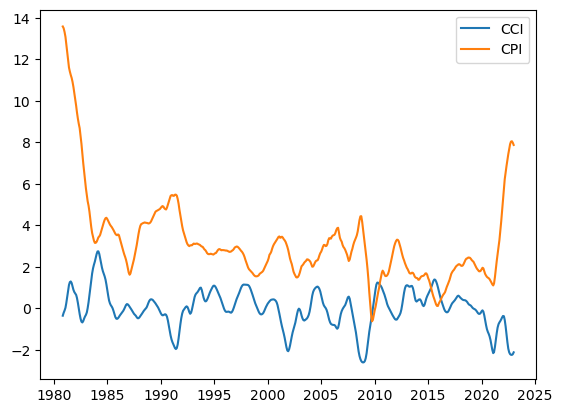

In [53]:
plt.plot(df_eco_test_2[features_to_flag[0]], label='CCI')
plt.plot(df_eco_test_2[features_to_flag[1]], label='CPI')
plt.legend()
plt.show()

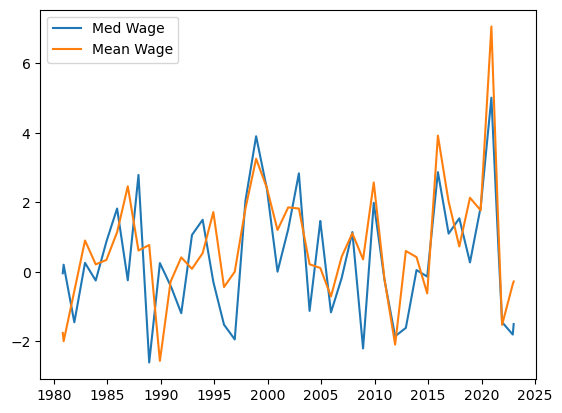

In [54]:
plt.plot(df_eco_test_2[features_to_flag[3]], label='Med Wage')
plt.plot(df_eco_test_2[features_to_flag[4]], label='Mean Wage')
plt.legend()
plt.show()

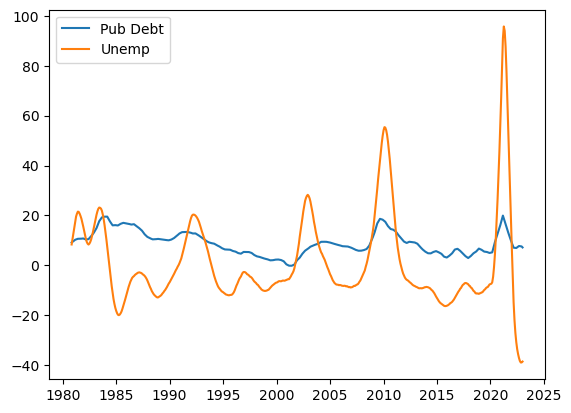

In [55]:
plt.plot(df_eco_test_2[features_to_flag[2]], label='Pub Debt')
plt.plot(df_eco_test_2[features_to_flag[5]], label='Unemp')
plt.legend()
plt.show()

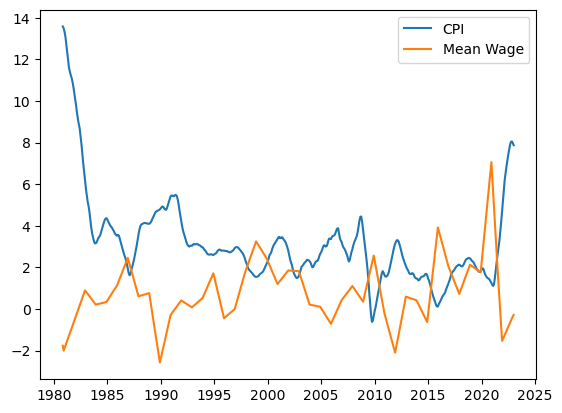

In [56]:
plt.plot(df_eco_test_2[features_to_flag[1]], label='CPI')
plt.plot(df_eco_test_2[features_to_flag[4]], label='Mean Wage')
plt.legend()
plt.show()

In [57]:
df_eco_test_2[features_to_flag].corr()

,CCI Rolling Percent Change,CPI Rolling Percent Change,Public Debt Rolling Percent Change,Median Annual Hourly Wage Rolling Percent Change,Mean Annual Hourly Wage Rolling Percent Change,Unemployment Rate Rolling Percent Change
CCI Rolling Percent Change,1.000000,-0.134977,0.034119,0.065353,-0.067155,-0.137571
CPI Rolling Percent Change,-0.134977,1.000000,0.163165,-0.426394,-0.547826,-0.038063
Public Debt Rolling Percent Change,0.034119,0.163165,1.000000,-0.126671,-0.127491,0.501754
Median Annual Hourly Wage Rolling Percent Change,0.065353,-0.426394,-0.126671,1.000000,0.772041,0.175185
Mean Annual Hourly Wage Rolling Percent Change,-0.067155,-0.547826,-0.127491,0.772041,1.000000,0.202908
Unemployment Rate Rolling Percent Change,-0.137571,-0.038063,0.501754,0.175185,0.202908,1.000000


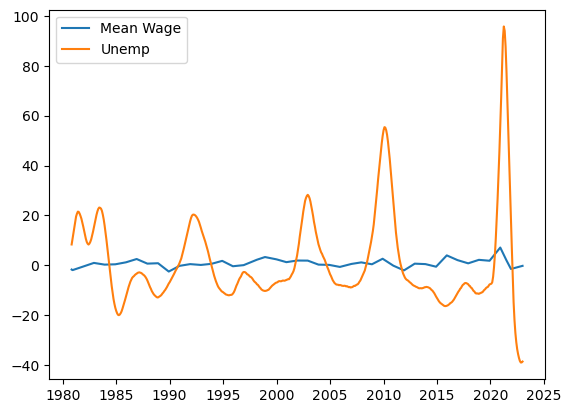

In [58]:
plt.plot(df_eco_test_2[features_to_flag[4]], label='Mean Wage')
plt.plot(df_eco_test_2[features_to_flag[5]], label='Unemp')
plt.legend()
plt.show()

In [59]:
df_eco_test_2.columns

Index(['CCI Value', 'CCI Rolling Mean', 'CCI Rolling Percent Change',
       'CPI Value', 'CPI Rolling Mean', 'CPI Rolling Percent Change',
       'Public Debt (bil USD)', 'Public Debt (bil USD) Rolling Mean',
       'Public Debt Rolling Percent Change', 'Median Annual Hourly Wage (USD)',
       'Mean Annual Hourly Wage (USD)',
       'Median Annual Hourly Wage (USD) Rolling Mean',
       'Median Annual Hourly Wage Rolling Percent Change',
       'Mean Annual Hourly Wage (USD) Rolling Mean',
       'Mean Annual Hourly Wage Rolling Percent Change',
       'Unemployment Rate (%)', 'Unemployment Rate (%) Rolling Mean',
       'Unemployment Rate Rolling Percent Change',
       'CCI Rolling Percent Change Flag', 'CPI Rolling Percent Change Flag',
       'Public Debt Rolling Percent Change Flag',
       'Median Annual Hourly Wage Rolling Percent Change Flag',
       'Mean Annual Hourly Wage Rolling Percent Change Flag',
       'Unemployment Rate Rolling Percent Change Flag'],
      dtype='ob

In [60]:
df_eco_test_2[[
    'Mean Annual Hourly Wage (USD)',
    'Mean Annual Hourly Wage (USD) Rolling Mean',
    'Mean Annual Hourly Wage Rolling Percent Change'
]].loc[df_eco_test_2.index < '1982-01-01']

,Mean Annual Hourly Wage (USD),Mean Annual Hourly Wage (USD) Rolling Mean,Mean Annual Hourly Wage Rolling Percent Change
Date,,,
1980-11-01,23.50,23.540000,-1.763172
1980-12-01,23.50,23.500000,-2.001668
1981-01-01,23.37,23.489167,-1.883180
1981-02-01,23.37,23.478333,-1.764296
1981-03-01,23.37,23.467500,-1.645013
1981-04-01,23.37,23.456667,-1.525329
1981-05-01,23.37,23.445833,-1.405243
1981-06-01,23.37,23.435000,-1.284751
1981-07-01,23.37,23.424167,-1.163854


In [61]:
df_eco_test_2[flag_cols].loc[
    (df_eco_test_2[flag_cols[0]] == 'strong negative') |
    (df_eco_test_2[flag_cols[0]] == 'moderate negative') &
    (df_eco_test_2[flag_cols[1]] == 'moderate positive') |
    (df_eco_test_2[flag_cols[1]] == 'strong positive') &
    (df_eco_test_2[flag_cols[5]] == 'moderate positive') |
    (df_eco_test_2[flag_cols[5]] == 'strong positive')
].shape

(95, 6)

In [62]:
df_eco_test_3 = df_economics.copy()

features_to_flag_2 = [
    'CCI Rolling Percent Change',
    'CPI Rolling Percent Change',
    'Unemployment Rate Rolling Percent Change'
]

# Defining a function to flag each feature in `features_to_flag`
def flag_economics_mk2(df, features_to_flag):
    for col in df[features_to_flag].columns:
        new_col = str(col) + ' Flag'
        df.loc[df[col] > 0, new_col] = 'positive'
        df.loc[df[col] <= 0, new_col] = 'negative'
    return df

# Applying `flag_economics`
df_eco_test_3 = flag_economics_mk2(df_eco_test_3, features_to_flag_2)

In [63]:
df_eco_test_2[features_to_flag_2].describe()

,CCI Rolling Percent Change,CPI Rolling Percent Change,Unemployment Rate Rolling Percent Change
count,507.000000,507.000000,507.000000
mean,0.009669,3.188011,1.057584
std,0.919494,2.179986,18.727424
min,-2.603210,-0.621247,-39.069767
25%,-0.396458,1.909764,-9.264461
50%,0.041793,2.791425,-5.798687
75%,0.547931,3.638977,9.330822
max,2.750711,13.584687,95.805740


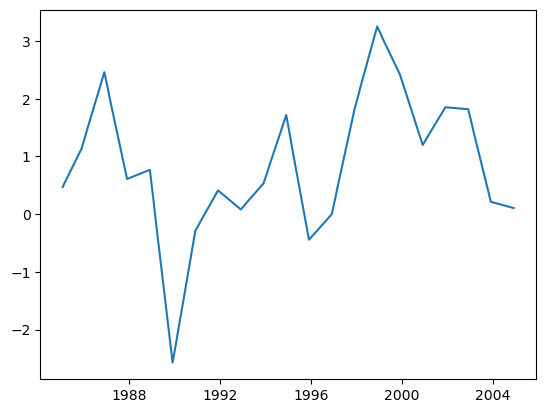

In [64]:
selection_sample_1 = df_eco_test_2['Mean Annual Hourly Wage Rolling Percent Change'].loc[
    (df_eco_test_2.index > '1985-01-01') &
    (df_eco_test_2.index < '2005-01-01')
]

# selection_sample_1 = df_eco_test_2['Mean Annual Hourly Wage Rolling Percent Change'].loc[
#     (df_eco_test_2['Mean Annual Hourly Wage Rolling Percent Change'] > -0.05) &
#     (df_eco_test_2['Mean Annual Hourly Wage Rolling Percent Change'] < 0.05) 
# ]

plt.plot(selection_sample_1)

In [65]:
flag_cols2 = [
    'CCI Rolling Percent Change Flag',
    'CPI Rolling Percent Change Flag',
    'Unemployment Rate Rolling Percent Change Flag'
]

df_eco_test_3[flag_cols2].head()

,CCI Rolling Percent Change Flag,CPI Rolling Percent Change Flag,Unemployment Rate Rolling Percent Change Flag
Date,,,
1980-11-01,negative,positive,positive
1980-12-01,negative,positive,positive
1981-01-01,negative,positive,positive
1981-02-01,positive,positive,positive
1981-03-01,positive,positive,positive


In [66]:
# D01 = +++
dist_01 = df_eco_test_3[flag_cols2].loc[
    (df_eco_test_3[flag_cols2[0]] == 'positive') &
    (df_eco_test_3[flag_cols2[1]] == 'positive') &
    (df_eco_test_3[flag_cols2[2]] == 'positive') 
].shape[0]

# D02 = ++-
dist_02 = df_eco_test_3[flag_cols2].loc[
    (df_eco_test_3[flag_cols2[0]] == 'positive') &
    (df_eco_test_3[flag_cols2[1]] == 'positive') &
    (df_eco_test_3[flag_cols2[2]] == 'negative') 
].shape[0]

# D03 = +-+
dist_03 = df_eco_test_3[flag_cols2].loc[
    (df_eco_test_3[flag_cols2[0]] == 'positive') &
    (df_eco_test_3[flag_cols2[1]] == 'negative') &
    (df_eco_test_3[flag_cols2[2]] == 'positive') 
].shape[0]

# D04 = -++
dist_04 = df_eco_test_3[flag_cols2].loc[
    (df_eco_test_3[flag_cols2[0]] == 'negative') &
    (df_eco_test_3[flag_cols2[1]] == 'positive') &
    (df_eco_test_3[flag_cols2[2]] == 'positive') 
].shape[0]

# D05 = --+
dist_05 = df_eco_test_3[flag_cols2].loc[
    (df_eco_test_3[flag_cols2[0]] == 'negative') &
    (df_eco_test_3[flag_cols2[1]] == 'negative') &
    (df_eco_test_3[flag_cols2[2]] == 'positive') 
].shape[0]

# D06= -+-
dist_06 = df_eco_test_3[flag_cols2].loc[
    (df_eco_test_3[flag_cols2[0]] == 'negative') &
    (df_eco_test_3[flag_cols2[1]] == 'positive') &
    (df_eco_test_3[flag_cols2[2]] == 'negative') 
].shape[0]

# D07 = +--
dist_07 = df_eco_test_3[flag_cols2].loc[
    (df_eco_test_3[flag_cols2[0]] == 'positive') &
    (df_eco_test_3[flag_cols2[1]] == 'negative') &
    (df_eco_test_3[flag_cols2[2]] == 'negative') 
].shape[0]

# D08 = ---
dist_08 = df_eco_test_3[flag_cols2].loc[
    (df_eco_test_3[flag_cols2[0]] == 'negative') &
    (df_eco_test_3[flag_cols2[1]] == 'negative') &
    (df_eco_test_3[flag_cols2[2]] == 'negative') 
].shape[0]

# # D10 = +-+-
# dist_10 = df_eco_test_3[flag_cols2].loc[
#     (df_eco_test_3[flag_cols2[0]] == 'positive') &
#     (df_eco_test_3[flag_cols2[1]] == 'positive') &
#     (df_eco_test_3[flag_cols2[2]] == 'positive') 
# ].shape[0]

# # D11 = -+-+
# dist_11 = df_eco_test_3[flag_cols2].loc[
#     (df_eco_test_3[flag_cols2[0]] == 'positive') &
#     (df_eco_test_3[flag_cols2[1]] == 'positive') &
#     (df_eco_test_3[flag_cols2[2]] == 'positive') 
# ].shape[0]

# # D12 = ---+
# dist_12 = df_eco_test_3[flag_cols2].loc[
#     (df_eco_test_3[flag_cols2[0]] == 'positive') &
#     (df_eco_test_3[flag_cols2[1]] == 'positive') &
#     (df_eco_test_3[flag_cols2[2]] == 'positive') 
# ].shape[0]

# # D13 = --+-
# dist_13 = df_eco_test_3[flag_cols2].loc[
#     (df_eco_test_3[flag_cols2[0]] == 'positive') &
#     (df_eco_test_3[flag_cols2[1]] == 'positive') &
#     (df_eco_test_3[flag_cols2[2]] == 'positive') 
# ].shape[0]

# # D14 = -+--
# dist_14 = df_eco_test_3[flag_cols2].loc[
#     (df_eco_test_3[flag_cols2[0]] == 'positive') &
#     (df_eco_test_3[flag_cols2[1]] == 'positive') &
#     (df_eco_test_3[flag_cols2[2]] == 'positive') 
# ].shape[0]

# # D15 = +---
# dist_15 = df_eco_test_3[flag_cols2].loc[
#     (df_eco_test_3[flag_cols2[0]] == 'positive') &
#     (df_eco_test_3[flag_cols2[1]] == 'positive') &
#     (df_eco_test_3[flag_cols2[2]] == 'positive') 
# ].shape[0]

# # D16 = ----
# dist_16 = df_eco_test_3[flag_cols2].loc[
#     (df_eco_test_3[flag_cols2[0]] == 'positive') &
#     (df_eco_test_3[flag_cols2[1]] == 'positive') &
#     (df_eco_test_3[flag_cols2[2]] == 'positive') 
# ].shape[0]

total_flags = dist_01 + dist_02 + dist_03 + dist_04 + dist_05 + dist_06 + dist_07 +\
              dist_08 #+ dist_09 + dist_10 + dist_11 + dist_12 + dist_13 + dist_14 +\
            #   dist_15 + dist_16

total_rows = df_eco_test_3.shape[0]

print(f'CCI | CPI | Unemp')
print(f' +  |  -  |  -  \n')
print(f'D01 = +++: {dist_01}')
print(f'D02 = ++-: {dist_02}')
print(f'D03 = +-+: {dist_03}')
print(f'D04 = -++: {dist_04}')
print(f'D05 = --+: {dist_05}')
print(f'D06 = -+-: {dist_06}')
print(f'D07 = +--: {dist_07}')
print(f'D08 = ---: {dist_08}\n')
# print(f'D09 = -++-: {dist_09}')
# print(f'D10 = +-+-: {dist_10}')
# print(f'D11 = -+-+: {dist_11}')
# print(f'D12 = ---+: {dist_12}')
# print(f'D13 = --+-: {dist_13}')
# print(f'D14 = -+--: {dist_14}')
# print(f'D15 = +---: {dist_15}')
# print(f'D16 = ----: {dist_16}\n')
print(f'For a total of {total_flags} of {total_rows} rows')
print(f'Remaining rows: {total_rows - total_flags}')

CCI | CPI | Unemp
 +  |  -  |  -  

D01 = +++: 70
D02 = ++-: 192
D03 = +-+: 3
D04 = -++: 99
D05 = --+: 2
D06 = -+-: 141
D07 = +--: 0
D08 = ---: 0

For a total of 507 of 507 rows
Remaining rows: 0


In [67]:
# display(df_eco_test_3['CCI Rolling Percent Change Flag'].value_counts())
# display(df_eco_test_3['CPI Rolling Percent Change Flag'].value_counts())
# display(df_eco_test_3['Mean Annual Hourly Wage Rolling Percent Change Flag'].value_counts())
# display(df_eco_test_3['Unemployment Rate Rolling Percent Change Flag'].value_counts())

In [68]:
df_eco_test_3[flag_cols2].loc[
    (df_eco_test_3[flag_cols2[0]] == 'stagnant') |
    (df_eco_test_3[flag_cols2[1]] == 'stagnant') |
    (df_eco_test_3[flag_cols2[2]] == 'stagnant') 
]

,CCI Rolling Percent Change Flag,CPI Rolling Percent Change Flag,Unemployment Rate Rolling Percent Change Flag
Date,,,


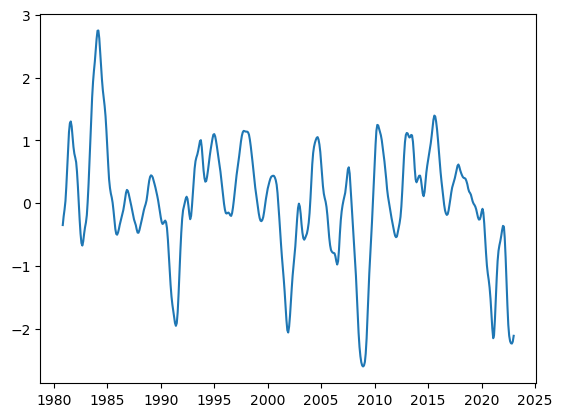

In [69]:
plt.plot(df_eco_test_3['CCI Rolling Percent Change'])

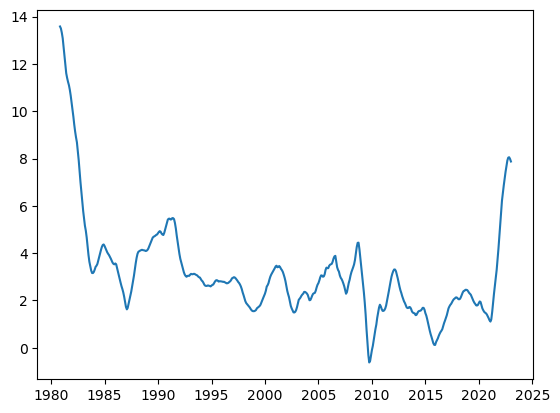

In [70]:
plt.plot(df_eco_test_3['CPI Rolling Percent Change'])

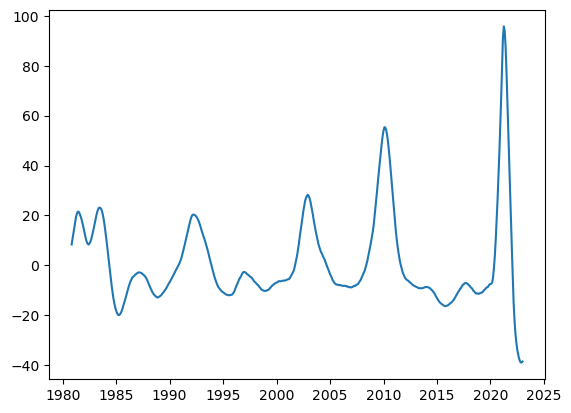

In [71]:
plt.plot(df_eco_test_3['Unemployment Rate Rolling Percent Change'])

In [72]:
col_list = df_economics.columns.to_list()

col_list

['CCI Value',
 'CCI Rolling Mean',
 'CCI Rolling Percent Change',
 'CPI Value',
 'CPI Rolling Mean',
 'CPI Rolling Percent Change',
 'Public Debt (bil USD)',
 'Public Debt (bil USD) Rolling Mean',
 'Public Debt Rolling Percent Change',
 'Median Annual Hourly Wage (USD)',
 'Mean Annual Hourly Wage (USD)',
 'Median Annual Hourly Wage (USD) Rolling Mean',
 'Median Annual Hourly Wage Rolling Percent Change',
 'Mean Annual Hourly Wage (USD) Rolling Mean',
 'Mean Annual Hourly Wage Rolling Percent Change',
 'Unemployment Rate (%)',
 'Unemployment Rate (%) Rolling Mean',
 'Unemployment Rate Rolling Percent Change']

In [73]:
col_target = [
    'CCI Value',
    'CCI Rolling Mean',
    'CCI Rolling Percent Change',
    'CPI Value',
    'CPI Rolling Mean',
    'CPI Rolling Percent Change',
    'Unemployment Rate (%)',
    'Unemployment Rate (%) Rolling Mean',
    'Unemployment Rate Rolling Percent Change'
]

col_target

['CCI Value',
 'CCI Rolling Mean',
 'CCI Rolling Percent Change',
 'CPI Value',
 'CPI Rolling Mean',
 'CPI Rolling Percent Change',
 'Unemployment Rate (%)',
 'Unemployment Rate (%) Rolling Mean',
 'Unemployment Rate Rolling Percent Change']

In [76]:
df_eco_concat = df_economics[col_target].copy()

features_to_flag_2 = [
    'CCI Rolling Percent Change',
    'CPI Rolling Percent Change',
    'Unemployment Rate Rolling Percent Change'
]

# Defining a function to flag each feature in `features_to_flag`
def flag_economics_mk2(df, features_to_flag):
    for col in df[features_to_flag].columns:
        new_col = str(col) + ' Flag'
        df.loc[df[col] > 0, new_col] = 'positive'
        df.loc[df[col] <= 0, new_col] = 'negative'
    return df

In [77]:
df_eco_concat = flag_economics_mk2(df_eco_concat, features_to_flag_2)
df_eco_concat.head()

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change,CCI Rolling Percent Change Flag,CPI Rolling Percent Change Flag,Unemployment Rate Rolling Percent Change Flag
Date,,,,,,,,,,,,
1980-11-01,98.49612,97.382044,-0.349702,85.6,81.591667,13.584687,7.2,6.416667,8.298172,negative,positive,positive
1980-12-01,98.12267,97.443947,-0.211242,86.4,82.383333,13.501722,7.3,6.533333,10.578279,negative,positive,positive
1981-01-01,97.97219,97.486225,-0.102107,87.2,83.150000,13.321976,7.4,6.658333,13.012730,negative,positive,positive
1981-02-01,97.87602,97.537902,0.033358,88.0,83.900000,13.085477,7.5,6.791667,15.439093,positive,positive,positive
1981-03-01,97.97713,97.643262,0.254283,88.6,84.608333,12.748473,7.6,6.925000,17.705382,positive,positive,positive


In [79]:
df_eco_concat['Economic Climate'] = 'PLACEHOLDER'

# D01 = +++                             Lean to Bad
df_eco_concat['Economic Climate'].loc[
    (df_eco_concat[flag_cols2[0]] == 'positive') &
    (df_eco_concat[flag_cols2[1]] == 'positive') &
    (df_eco_concat[flag_cols2[2]] == 'positive') 
] = 'Lean to Bad'

# D02 = ++-                             Comfortable to Good
df_eco_concat['Economic Climate'].loc[
    (df_eco_concat[flag_cols2[0]] == 'positive') &
    (df_eco_concat[flag_cols2[1]] == 'positive') &
    (df_eco_concat[flag_cols2[2]] == 'negative') 
] = 'Comfortable to Good'

# D03 = +-+                             Comfortable to Good
df_eco_concat['Economic Climate'].loc[
    (df_eco_concat[flag_cols2[0]] == 'positive') &
    (df_eco_concat[flag_cols2[1]] == 'negative') &
    (df_eco_concat[flag_cols2[2]] == 'positive') 
] = 'Comfortable to Good'

# D04 = -++                             Lean to Bad
df_eco_concat['Economic Climate'].loc[
    (df_eco_concat[flag_cols2[0]] == 'negative') &
    (df_eco_concat[flag_cols2[1]] == 'positive') &
    (df_eco_concat[flag_cols2[2]] == 'positive') 
] = 'Lean to Bad'

# D05 = --+                             Lean to Bad
df_eco_concat['Economic Climate'].loc[
    (df_eco_concat[flag_cols2[0]] == 'negative') &
    (df_eco_concat[flag_cols2[1]] == 'negative') &
    (df_eco_concat[flag_cols2[2]] == 'positive') 
] = 'Lean to Bad'

# D06= -+-                              Lean to Bad
df_eco_concat['Economic Climate'].loc[
    (df_eco_concat[flag_cols2[0]] == 'negative') &
    (df_eco_concat[flag_cols2[1]] == 'positive') &
    (df_eco_concat[flag_cols2[2]] == 'negative') 
] = 'Lean to Bad'

# D07 = +--                             Comfortable to Good
df_eco_concat['Economic Climate'].loc[
    (df_eco_concat[flag_cols2[0]] == 'positive') &
    (df_eco_concat[flag_cols2[1]] == 'negative') &
    (df_eco_concat[flag_cols2[2]] == 'negative') 
] = 'Comfortable to Good'

# D08 = ---                             Comfortable to Good
df_eco_concat['Economic Climate'].loc[
    (df_eco_concat[flag_cols2[0]] == 'negative') &
    (df_eco_concat[flag_cols2[1]] == 'negative') &
    (df_eco_concat[flag_cols2[2]] == 'negative') 
] = 'Comfortable to Good'

display(df_eco_concat.head())
display(df_eco_concat.tail())

C:\Users\joblu\AppData\Local\Temp\ipykernel_10788\3958857066.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_eco_concat['Economic Climate'].loc[
C:\Users\joblu\AppData\Local\Temp\ipykernel_10788\3958857066.py:4: SettingWithCopyWarning

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change,CCI Rolling Percent Change Flag,CPI Rolling Percent Change Flag,Unemployment Rate Rolling Percent Change Flag,Economic Climate
Date,,,,,,,,,,,,,
1980-11-01,98.49612,97.382044,-0.349702,85.6,81.591667,13.584687,7.2,6.416667,8.298172,negative,positive,positive,Lean to Bad
1980-12-01,98.12267,97.443947,-0.211242,86.4,82.383333,13.501722,7.3,6.533333,10.578279,negative,positive,positive,Lean to Bad
1981-01-01,97.97219,97.486225,-0.102107,87.2,83.150000,13.321976,7.4,6.658333,13.012730,negative,positive,positive,Lean to Bad
1981-02-01,97.87602,97.537902,0.033358,88.0,83.900000,13.085477,7.5,6.791667,15.439093,positive,positive,positive,Lean to Bad
1981-03-01,97.97713,97.643262,0.254283,88.6,84.608333,12.748473,7.6,6.925000,17.705382,positive,positive,positive,Lean to Bad


,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change,CCI Rolling Percent Change Flag,CPI Rolling Percent Change Flag,Unemployment Rate Rolling Percent Change Flag,Economic Climate
Date,,,,,,,,,,,,,
2022-09-01,96.65869,97.130987,-2.200527,296.539,287.657917,7.916538,3.8,4.700000,-37.263626,negative,positive,negative,Lean to Bad
2022-10-01,96.77125,97.012161,-2.233606,297.987,289.446667,8.039206,3.7,4.525000,-38.435374,negative,positive,negative,Lean to Bad
2022-11-01,96.83717,96.912108,-2.238188,298.598,291.103917,8.056224,3.7,4.366667,-39.069767,negative,positive,negative,Lean to Bad
2022-12-01,97.05321,96.838357,-2.207781,298.990,292.612500,7.986482,3.6,4.225000,-39.062500,negative,positive,negative,Lean to Bad
2023-01-01,97.33643,96.807437,-2.114485,300.536,294.107250,7.876285,3.6,4.091667,-38.701623,negative,positive,negative,Lean to Bad


In [80]:
df_eco_concat['Economic Climate'].value_counts()

Economic Climate
Lean to Bad            312
Comfortable to Good    195
Name: count, dtype: int64

In [81]:
df_eco_concat.to_csv('./economics_data.csv')